*CIFAR10 data set*

The CIFAR-10 dataset consists of 60000 **32x32** colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.


| Version               | Size   | MD5 Sum                          |
|:---------------------:|:------:|:--------------------------------:|
| CIFAR-10 python version | 163 MB | c58f30108f718f92721af3b95e74349a |




In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

In [37]:
# 1. 장치 설정 함수
def get_device() -> torch.device:
    """
    사용 가능한 장치를 반환합니다. GPU가 사용 가능하면 GPU를, 그렇지 않으면 CPU를 반환합니다.
    
    Returns:
        torch.device: 사용 가능한 장치
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f'사용 장치: {device}')
    return device

**torch.device**
- PyTorch에서 장치를 표현하는 클래스의 객체 타입
- torch.deivce("cpu") 또는 torch.device("cuda") 와 같이 표현
- torch.device는 PyTorch에서 장치를 표현하는 클래스. 이 클래스에는 __str__ 메서드가 구현되어 있어, 객체를 문자열로 표현할 때 사람이 읽기 쉬운 형식으로 변환됨

**get_device() -> torch.device:**
- get_device()함수의 반환 값이 torch.device 타입이라는 것을 의미

In [38]:
# 2. 데이터 로드 및 전처리 함수
def load_data(batch_size_train: int = 64, 
              batch_size_test: int = 100, 
              num_workers: int = 2) -> tuple:
    """
    CIFAR-10 데이터셋을 로드하고 전처리합니다.
    
    Args:
        batch_size_train (int, optional): 학습 데이터 배치 크기. Defaults to 64.
        batch_size_test (int, optional): 테스트 데이터 배치 크기. Defaults to 100.
        num_workers (int, optional): 데이터 로드 시 사용할 워커 수. Defaults to 2.
    
    Returns:
        tuple: (trainloader, testloader, classes)
    """
    transform_train = transforms.Compose([
        transforms.RandomHorizontalFlip(),  # 데이터 증강: 수평 뒤집기
        transforms.RandomCrop(32, padding=4),  # 데이터 증강: 랜덤 크롭
        transforms.ToTensor(),  # 텐서로 변환
        transforms.Normalize(mean=(0.4914, 0.4822, 0.4465),  # 정규화 (평균)
                             std=(0.2023, 0.1994, 0.2010))  # 정규화 (표준편차)
    ])
    
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.4914, 0.4822, 0.4465),
                             std=(0.2023, 0.1994, 0.2010))
    ])
    
    # 학습 데이터셋
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform_train)
    trainloader = DataLoader(trainset, batch_size=batch_size_train,
                             shuffle=True, num_workers=num_workers)
    
    # 테스트 데이터셋
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)
    testloader = DataLoader(testset, batch_size=batch_size_test, 
                            shuffle=False, num_workers=num_workers)
    
    # 클래스 이름 정의
    classes = ['airplane', 'car', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
    
    return trainloader, testloader, classes

*학습 데이터 배치 사이즈와 테스트 데이터 배치 사이즈가 다른 이유*

**학습 과정** 
- 순전파(forward pass)와 역전파(backward pass)를 모두 계산해야 하므로, GPU 또는 CPU 메모리를 더 많이 소비합니다.
- 성능과 안정성: 너무 작은 배치 크기: 모델 학습이 불안정하고, 학습 시간이 길어질 수 있음.
- 너무 큰 배치 크기: 메모리 부족 문제가 발생하거나 일반화 성능이 저하될 수 있음.

**테스트** 
- 모델이 새로운 데이터에서 얼마나 잘 동작하는지 확인하는 것이 목적이므로, 배치 크기는 학습에 비해 큰 영향을 미치지 않습니다.

In [39]:
# 3. 데이터 시각화 함수
def visualize_data(trainloader: DataLoader, classes: list):
    """
    학습 데이터셋의 일부 샘플을 시각화합니다.
    
    Args:
        trainloader (DataLoader): 학습 데이터 로더
        classes (list): 클래스 이름 리스트
    """
    def imshow(img):
        img = img * torch.tensor([0.2023, 0.1994, 0.2010]).view(3,1,1) + torch.tensor([0.4914, 0.4822, 0.4465]).view(3,1,1)  # 정규화 해제
        npimg = img.numpy() # PyTorch 텐서를 넘파이 배열로 변환
        plt.imshow(np.transpose(npimg, (1, 2, 0))) # PyTorch 텐서는 (C, H, W) 형식이므로 이를 (H, W, C) 형식으로 변경
        # plt.imshow는 이미지를 표시할 수 있도록 준비 -> 렌더링
        plt.show() #  plt.show는 현재까지 준비된 모든 플롯(그래프, 이미지 등)을 화면에 출력
    
    # 데이터 샘플 확인
    dataiter = iter(trainloader)
    images, labels = next(dataiter)

    
    imshow(torchvision.utils.make_grid(images[:16]))
    # torchvision.utils.make_grid:
    # images[:16]: 첫 번째 배치에서 16개의 이미지를 선택합니다.
    # torchvision.utils.make_grid():
    # 선택된 이미지를 그리드(grid) 형식으로 정렬하여 하나의 큰 이미지로 만듭니다.
    print(' '.join(f'{classes[labels[j]]:5s}' for j in range(16)))
    

*정규화 식*
$$
x_{\text{normalized}} = \frac{x - \text{mean}}{\text{std}}
$$

*정규화 해제*
$$
x = x_{\text{normalized}} \cdot \text{std} + \text{mean}
$$


In [40]:
# 4. CNN 모델 정의 함수 (명명된 인자 사용)
def define_model() -> nn.Module:
    """
    CNN 모델을 정의합니다.
    
    Returns:
        nn.Module: 정의된 CNN 모델
    """
    class Net(nn.Module):
        def __init__(self):
            super(Net, self).__init__()
            # 첫 번째 Convolutional Layer
            self.conv1 = nn.Conv2d(
                in_channels=3,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1
            )
            self.bn1 = nn.BatchNorm2d(num_features=32) # conv1 출력 (64x32x32x32)에 배치 정규화 적용 (32개 각 채널별로 정규화)
            
            # 두 번째 Convolutional Layer
            self.conv2 = nn.Conv2d(
                in_channels=32,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1
            )
            self.bn2 = nn.BatchNorm2d(num_features=32)
            
            # Max Pooling
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
            self.dropout = nn.Dropout(p=0.25)
            
            # 세 번째 Convolutional Layer
            self.conv3 = nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=1
            )
            self.bn3 = nn.BatchNorm2d(num_features=64)
            
            # 네 번째 Convolutional Layer
            self.conv4 = nn.Conv2d(
                in_channels=64,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=1
            )
            self.bn4 = nn.BatchNorm2d(num_features=64)
            self.dropout2 = nn.Dropout(p=0.25)
            
            # Fully Connected Layers
            self.fc1 = nn.Linear(
                in_features=64 * 8 * 8,
                out_features=512
            )
            self.bn5 = nn.BatchNorm1d(num_features=512)
            self.dropout3 = nn.Dropout(p=0.5)
            self.fc2 = nn.Linear(
                in_features=512,
                out_features=10
            )
        
        def forward(self, x):
            # 첫 번째 블록
            x = torch.relu(self.bn1(self.conv1(x)))
            x = torch.relu(self.bn2(self.conv2(x)))
            x = self.pool(x)
            x = self.dropout(x)
            
            # 두 번째 블록
            x = torch.relu(self.bn3(self.conv3(x)))
            x = torch.relu(self.bn4(self.conv4(x)))
            x = self.pool(x)
            x = self.dropout2(x)
            
            # 완전 연결층
            x = x.view(-1, 64 * 8 * 8)
            x = torch.relu(self.bn5(self.fc1(x)))
            x = self.dropout3(x)
            x = self.fc2(x)
            return x
    
    net = Net()
    print(net)
    return net

In [41]:
# 5. 손실 함수 및 옵티마이저 정의 함수
def get_criterion_optimizer(model: nn.Module, learning_rate: float = 0.001) -> tuple:
    """
    손실 함수와 옵티마이저를 정의합니다.
    
    Args:
        model (nn.Module): 학습할 모델
        learning_rate (float, optional): 학습률. Defaults to 0.001.
    
    Returns:
        tuple: (손실 함수, 옵티마이저)
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(params=model.parameters(), lr=learning_rate)
    return criterion, optimizer

In [42]:
# 6. 모델 학습 함수
def train_model(model: nn.Module, 
                trainloader: DataLoader, 
                testloader: DataLoader, 
                criterion: nn.Module, 
                optimizer: optim.Optimizer, 
                device: torch.device, 
                num_epochs: int = 50) -> dict:
    """
    모델을 학습시킵니다.
    
    Args:
        model (nn.Module): 학습할 모델
        trainloader (DataLoader): 학습 데이터 로더
        testloader (DataLoader): 테스트 데이터 로더
        criterion (nn.Module): 손실 함수
        optimizer (optim.Optimizer): 옵티마이저
        device (torch.device): 사용 장치
        num_epochs (int, optional): 학습할 에포크 수. Defaults to 50.
    
    Returns:
        dict: 학습 및 검증 손실과 정확도 기록
    """
    history = {
        'train_losses': [],
        'train_accuracies': [],
        'test_losses': [],
        'test_accuracies': []
    }
    
    for epoch in range(num_epochs):  # 에포크 수
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()  # 기울기 초기화
            
            outputs = model(inputs)  # 순전파
            loss = criterion(outputs, labels)  # 손실 계산
            loss.backward()  # 역전파
            optimizer.step()  # 가중치 업데이트
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(trainloader.dataset)
        epoch_acc = correct / total
        history['train_losses'].append(epoch_loss)
        history['train_accuracies'].append(epoch_acc)
        
        # 검증 단계
        model.eval()
        test_loss = 0.0
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()
        
        epoch_test_loss = test_loss / len(testloader.dataset)
        epoch_test_acc = correct_test / total_test
        history['test_losses'].append(epoch_test_loss)
        history['test_accuracies'].append(epoch_test_acc)
        
        print(f'Epoch [{epoch+1}/{num_epochs}] '
              f'Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} '
              f'| Test Loss: {epoch_test_loss:.4f} | Test Acc: {epoch_test_acc:.4f}')
    
    print('train complete')
    return history

In [43]:
# 7. 모델 평가 함수
def evaluate_model(model: nn.Module, 
                   testloader: DataLoader, 
                   device: torch.device) -> float:
    """
    테스트 데이터셋을 사용하여 모델을 평가합니다.
    
    Args:
        model (nn.Module): 평가할 모델
        testloader (DataLoader): 테스트 데이터 로더
        device (torch.device): 사용 장치
    
    Returns:
        float: 테스트 정확도
    """
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    test_accuracy = correct / total
    print(f'\nfinal test accuracy: {test_accuracy:.4f}')
    return test_accuracy

In [44]:
# 8. 학습 과정 시각화 함수
def plot_history(history: dict, num_epochs: int):
    """
    학습 과정에서의 손실과 정확도를 시각화합니다.
    
    Args:
        history (dict): 학습 및 검증 손실과 정확도 기록
        num_epochs (int): 에포크 수
    """
    epochs = range(1, num_epochs + 1)
    
    plt.figure(figsize=(12,5))
    
    # 정확도 변화
    plt.subplot(1,2,1)
    plt.plot(epochs, history['train_accuracies'], label='train accuracy')
    plt.plot(epochs, history['test_accuracies'], label='test accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('accuracy change')
    plt.legend()
    
    # 손실 변화
    plt.subplot(1,2,2)
    plt.plot(epochs, history['train_losses'], label='train loss')
    plt.plot(epochs, history['test_losses'], label='test loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('loss change')
    plt.legend()
    
    plt.show()

사용 장치: cpu
Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9802322e-08..1.0].


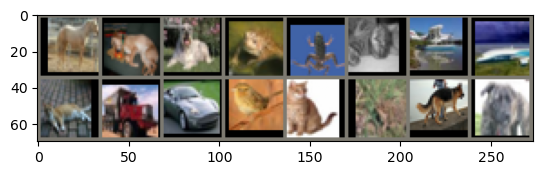

말     개     개     개구리   개구리   고양이   비행기   비행기   고양이   트럭    자동차   새     고양이   개구리   개     개    
Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=4096, out_features=512, bias=True)

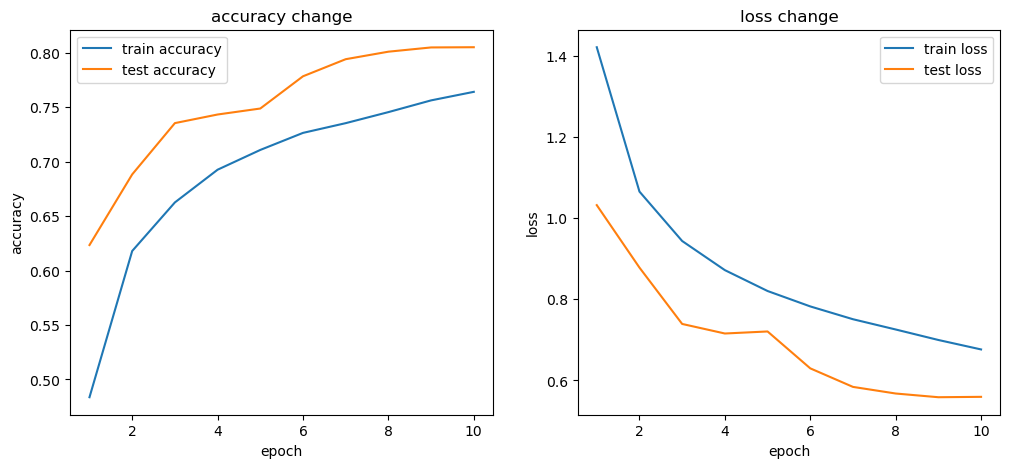

In [45]:
# 9. 메인 함수
def main():
    # 장치 설정
    device = get_device()
    
    # 데이터 로드
    trainloader, testloader, classes = load_data()
    
    # 데이터 시각화
    visualize_data(trainloader, classes)
    
    # 모델 정의
    model = define_model().to(device)
    
    # 손실 함수와 옵티마이저 정의
    criterion, optimizer = get_criterion_optimizer(model)
    
    # 모델 학습
    num_epochs = 10
    history = train_model(model, trainloader, testloader, criterion, optimizer, device, num_epochs)
    
    # 모델 평가
    evaluate_model(model, testloader, device)
    
    # 학습 과정 시각화
    plot_history(history, num_epochs)

if __name__ == '__main__':
    main()